In [1]:
# Cargar Datos CSV
import pandas as pd
data = pd.read_csv('DatosSingapore2.csv')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Detectar columnas binarias
binary_vars = [col for col in data.columns 
               if set(data[col].dropna().unique()).issubset({0, 1})]

# 2. Detectar columnas numéricas verdaderas
numerical_vars = data.select_dtypes(include=['number']).columns
numerical_true = [col for col in numerical_vars if col not in binary_vars]

# 3. Features
X = data[binary_vars + numerical_true]

# 4. Escalar únicamente numéricas continuas
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_true] = scaler.fit_transform(X[numerical_true])

# 🔥 PASO CRÍTICO: convertir todo a float32
X_scaled = X_scaled.astype("float32")

# 5. Target
y = data["price"].astype("float32")

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Epoch 1/50
62/62 [==============================] - 1s 4ms/step - loss: 68397.6953 - mean_absolute_error: 210.2099 - val_loss: 44080.2773 - val_mean_absolute_error: 163.4438
Epoch 2/50
62/62 [==============================] - 0s 2ms/step - loss: 18617.6094 - mean_absolute_error: 94.9875 - val_loss: 9010.8799 - val_mean_absolute_error: 71.2488
Epoch 3/50
62/62 [==============================] - 0s 2ms/step - loss: 7040.7139 - mean_absolute_error: 59.2942 - val_loss: 6584.1768 - val_mean_absolute_error: 60.0086
Epoch 4/50
62/62 [==============================] - 0s 2ms/step - loss: 5072.8213 - mean_absolute_error: 49.4202 - val_loss: 4587.0117 - val_mean_absolute_error: 49.0819
Epoch 5/50
62/62 [==============================] - 0s 2ms/step - loss: 3430.0298 - mean_absolute_error: 40.2140 - val_loss: 2936.9368 - val_mean_absolute_error: 38.4969
Epoch 6/50
62/62 [==============================] - 0s 3ms/step - loss: 2102.0178 - mean_absolute_error: 31.5199 - val_loss: 1639.2288 - val_mean

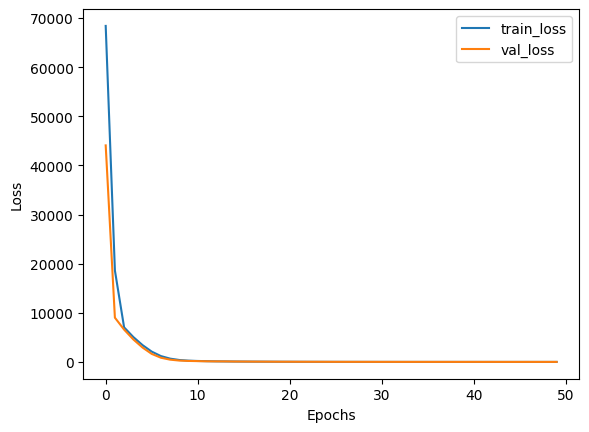

16/16 [==============================] - 0s 1ms/step
Teacher MSE: 7.3280, MAE: 1.6599


In [3]:
import tensorflow as tf
from tensorflow import keras

def create_teacher_model(input_dim):
    model = keras.Sequential()

    # Input
    model.add(keras.layers.Input(shape=(input_dim,)))

    # 2 capas ocultas
    for _ in range(2):
        model.add(keras.layers.Dense(128, activation="elu"))

    # Capa de salida
    model.add(keras.layers.Dense(1, activation="linear"))

    # Compilación
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )

    return model

teacher = create_teacher_model(X_train.shape[1])

history_teacher = teacher.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# graficar la historia de entrenamiento
import matplotlib.pyplot as plt
plt.plot(history_teacher.history['loss'], label='train_loss')
plt.plot(history_teacher.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# =========================================================
# PREDICCIONES DEL TEACHER PARA DISTILLATION
# =========================================================
teacher_train_preds = teacher.predict(X_train).astype("float32")
teacher_test_preds  = teacher.predict(X_test).astype("float32")

teacher_train_preds_log = np.log1p(teacher_train_preds)
teacher_test_preds_log = np.log1p(teacher_test_preds)

# Evaluar desempeño del teacher
mse_teacher = teacher.evaluate(X_test, y_test, verbose=0)
print(f"Teacher MSE: {mse_teacher[0]:.4f}, MAE: {mse_teacher[1]:.4f}")

In [4]:

# =========================================================
# 1) SELECCIÓN AUTOMÁTICA DE VARIABLES (NUMÉRICAS + CATEGÓRICAS)
# =========================================================
# Correlación numéricas con price
corr_num = data.corr(numeric_only=True)['price'].abs().sort_values(ascending=False)
top_num_vars = [v for v in corr_num.index if v != 'price'][:20]

# Inicializamos lista con numéricas
X_parts = [data[top_num_vars].copy()]

# Categóricas importantes
cat_cols = [col for col in ["room_type", "property_type", "host_response_time"] if col in data.columns]

if cat_cols:  # Solo si hay categóricas
    X_cat_full = pd.get_dummies(data[cat_cols].astype(str), prefix=cat_cols)
    
    if not X_cat_full.empty:  # Verificamos que no esté vacío
        # Correlación categóricas con price
        corr_cat = X_cat_full.apply(lambda col: col.corr(data['price'])).abs().sort_values(ascending=False)
        top_cat_vars = corr_cat.index[:10]  # Top 10 dummies más correlacionadas
        X_parts.append(X_cat_full[top_cat_vars])

# Concatenar solo si hay partes
if X_parts:
    X_student = pd.concat(X_parts, axis=1).fillna(0)
else:
    raise ValueError("No hay variables numéricas ni categóricas para crear el dataset.")

# =========================================================
# 2) ESCALADO Y ALINEACIÓN
# =========================================================
X_train_student = X_student.loc[X_train.index].copy()
X_test_student  = X_student.loc[X_test.index].copy()

scaler_student = StandardScaler()
X_train_student[top_num_vars] = scaler_student.fit_transform(X_train_student[top_num_vars])
X_test_student[top_num_vars]  = scaler_student.transform(X_test_student[top_num_vars])

# Convertir a float32
X_train_student = X_train_student.astype("float32")
X_test_student  = X_test_student.astype("float32")

# Targets
#y_train_student = y_train.astype("float32")
#y_test_student  = y_test.astype("float32")


# Targets con log-transform
y_train_student = np.log1p(y_train).astype("float32")
y_test_student  = np.log1p(y_test).astype("float32")


Epoch 1/50
62/62 [==============================] - 1s 6ms/step - loss: 11.7492 - mean_absolute_error: 2.9464 - val_loss: 1.8009 - val_mean_absolute_error: 0.7575
Epoch 2/50
62/62 [==============================] - 0s 3ms/step - loss: 2.3576 - mean_absolute_error: 1.0706 - val_loss: 0.8055 - val_mean_absolute_error: 0.5482
Epoch 3/50
62/62 [==============================] - 0s 4ms/step - loss: 1.6383 - mean_absolute_error: 0.8923 - val_loss: 0.6733 - val_mean_absolute_error: 0.5333
Epoch 4/50
62/62 [==============================] - 0s 3ms/step - loss: 1.3161 - mean_absolute_error: 0.8202 - val_loss: 0.4762 - val_mean_absolute_error: 0.3849
Epoch 5/50
62/62 [==============================] - 0s 3ms/step - loss: 1.1095 - mean_absolute_error: 0.7388 - val_loss: 0.4392 - val_mean_absolute_error: 0.3633
Epoch 6/50
62/62 [==============================] - 0s 3ms/step - loss: 1.0009 - mean_absolute_error: 0.6899 - val_loss: 0.4142 - val_mean_absolute_error: 0.3405
Epoch 7/50
62/62 [=========

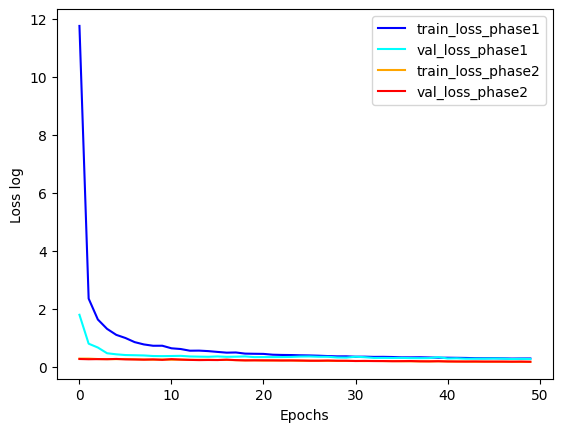

16/16 [==============================] - 0s 1ms/step
RMSE: 94.42, MAPE: 29.21%


In [ ]:

# =========================================================
# 1) CREAR MODELO STUDENT
# =========================================================
#def create_student_model(input_dim):
#    model = keras.Sequential([
#        keras.layers.Input(shape=(input_dim,)),
#        keras.layers.Dense(128, activation="elu"),
#        keras.layers.Dense(64, activation="elu"),
#        keras.layers.Dense(32, activation="elu"),
#        keras.layers.Dense(1, activation="linear")
#    ])
#    model.compile(
#        optimizer=keras.optimizers.Adam(learning_rate=0.001),
#        loss="mean_squared_error",
#        metrics=["mean_absolute_error"]
#    )
#    return model


def create_student_model(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(256, activation="elu", kernel_regularizer=keras.regularizers.l2(0.0005)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="elu", kernel_regularizer=keras.regularizers.l2(0.0005)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="elu"),
        keras.layers.Dense(1, activation="linear")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )
    return model


student = create_student_model(X_train_student.shape[1])

# =========================================================
# 2) ENTRENAMIENTO EN DOS FASES
# =========================================================

# Fase 1: aprender del Teacher (soft targets)
history_student_phase1 = student.fit(
    X_train_student, teacher_train_preds_log,
    validation_data=(X_test_student, teacher_test_preds_log),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Fase 2: fine-tuning con datos reales (hard targets)
history_student_phase2 = student.fit(
    X_train_student, y_train_student,
    validation_data=(X_test_student, y_test_student),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Graficar historia de entrenamiento del Student con fases de diferentes colores
plt.plot(history_student_phase1.history['loss'], label='train_loss_phase1', color='blue')
plt.plot(history_student_phase1.history['val_loss'], label='val_loss_phase1', color='cyan')
plt.plot(history_student_phase2.history['loss'], label='train_loss_phase2', color='orange')
plt.plot(history_student_phase2.history['val_loss'], label='val_loss_phase2', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss log')
plt.legend()
plt.show()

# Mostrar mse y mae finales del student
#mse_student = student.evaluate(X_test_student, y_test_student, verbose=0)
#print(f"Student MSE: {mse_student[0]:.4f}, MAE: {mse_student[1]:.4f}")

# Predicciones en escala original
y_pred = np.expm1(student.predict(X_test_student))

# Métricas reales
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
